<a href="https://colab.research.google.com/github/lucianeb/colab/blob/main/02_Fronteira_Eficiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed


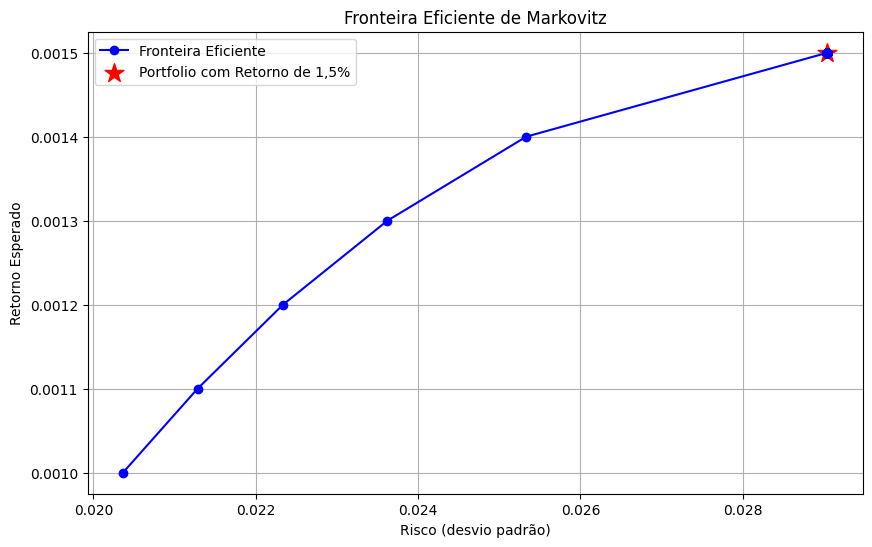

In [ ]:
# Importar libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Download dos dados
tickers = ['PETR4.SA', 'VALE3.SA', 'EMBR3.SA', 'LREN3.SA', 'ITUB4.SA']
data = yf.download(tickers, start="2020-01-01", end="2024-07-31")['Adj Close']

# Calcular retornos
returns = data.pct_change().dropna()

# Calcular retornos esperados e matriz de covariância
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Definir funções para otimização de portfolio
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_ret - risk_free_rate) / p_var

def optimize_portfolio(mean_returns, cov_matrix, return_target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - return_target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Construir fronteira eficiente

# Determinar os targets the retorno
target_returns = np.arange(0.001, 0.05, 0.0001)
efficient_portfolios = []

for target in target_returns:
    efficient_portfolios.append(optimize_portfolio(mean_returns, cov_matrix, target))

# Extrair riscos e retornos na fronteira eficiente
risks = [portfolio_performance(x['x'], mean_returns, cov_matrix)[0] for x in efficient_portfolios]
returns = [portfolio_performance(x['x'], mean_returns, cov_matrix)[1] for x in efficient_portfolios]

# Plotar a fronteira eficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, marker='o', linestyle='-', color='b', label='Fronteira Eficiente')
plt.xlabel('Risco (desvio padrão)')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente de Markovitz')

# Destaque para o portfolio com retorno de 1,5%
target_index = np.argmin(np.abs(np.array(returns) - 0.015))
plt.scatter(risks[target_index], returns[target_index], color='r', marker='*', s=200, label='Portfolio com Retorno de 1,5%')

plt.legend()
plt.grid(True)
plt.show()